In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from  matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import seaborn as sn
import sys
import os
from pathlib import Path
from tqdm import tqdm
from timeit import default_timer as timer
from datetime import timedelta

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from typing import Tuple, Union
from sklearn.utils.validation import check_is_fitted
from scipy.linalg import solve

import scipy

# import custom functions from src folder
module_path = str(Path.cwd() / "../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from SequentialNet import SequentialNet
from machine_learning import *
from util import *


In [2]:
sn.set_palette("tab10")
sn.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [3]:
def plot_logit_results(df, pred_key, ax, suptitle, grid=False, error_key=None, pred_min=0, pred_max=1, error_min=0.1, error_max=0.2):
    ax.set_title(suptitle)
    #sn.set_theme(style="whitegrid")

    cmap = red_blue_cmap()
    if grid:
        ax.hist2d(x= df["x1"], y=df["x2"], weights=df[pred_key], 
                bins = 100,
                #norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                cmap=cmap)
    else:
        if (error_key == None):
            sn.scatterplot(data = df, x="x1", y="x2", ax = ax, hue=pred_key, 
                        #hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                            palette=cmap, legend=False)
        else:
            sn.scatterplot(data = df, x="x1", y="x2", ax = ax, hue=pred_key, 
                        #hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                        size=error_key, #size_norm = (0.1, 0.2), sizes=(10, 200),
                            palette=cmap, legend=False)
    
    ax.set_xlim(-25, 25)
    ax.set_ylim(-25, 25)
    ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
    ax.tick_params(which="major", length=6)
    ax.minorticks_on()
    ax.set_aspect('equal', adjustable='box')

    return ax

In [4]:
# Machine learning options
x1_key = "x1"
x2_key = "x2"
n_data = [1000, 500, 2000, 3000, 5000]

#Data constants
R2 = 3
k_red = 7
k_blue = 3
R1_min = 6
scale = 1
vary_a1 = False
vary_R2 = False
p_red = 0.5
polar = False
tag = f'r2_{R2}_kr{k_red}_kb{k_blue}_r1min{R1_min}_s{scale}_vary_r2_{vary_R2}_vary_a1_{vary_a1}_pRed_{p_red}'

# Read files
train_n = 50000
trainfile = f"train_n_{train_n}_{tag}"
valfile = f"val_n_5000_{tag}"
testfile = f"test_n_10000_{tag}"
truthfile = f"analytical_solution_x1_x2_grid_{tag}_nxMC_100_nr1MC_50"
gridfile = "x1_x2_grid"

train_data = pd.read_csv(f"../data/{trainfile}.csv")
val_data = pd.read_csv(f"../data/{valfile}.csv")
test_data = pd.read_csv(f"../data/{testfile}.csv")
grid_data = pd.read_csv(f"../data/{gridfile}.csv")
truth_data = pd.read_csv(f"../analytical/results/{truthfile}.csv")
truth_data = truth_data[truth_data["r_x"] > R1_min-R2]

#Correct analytical solution if class distribution is not equal
if p_red != 0.5:
    truth_data["P_red_and_x"] = truth_data["P_red_and_x"]*(p_red)/0.5
    truth_data["P_blue_and_x"] = truth_data["P_blue_and_x"]*(1-p_red)/0.5
    truth_data["P_x"] = truth_data["P_red_and_x"] + truth_data["P_blue_and_x"]
    truth_data["P_red_given_x"] = truth_data["P_red_and_x"]/truth_data["P_x"]
    truth_data["P_blue_given_x"] = truth_data["P_blue_and_x"]/truth_data["P_x"]

X_test = test_data[[x1_key, x2_key]]
Y_test = test_data["class"]

X_grid = grid_data[[x1_key, x2_key]]

In [5]:
# https://www.geeksforgeeks.org/gaussian-process-classification-gpc-on-iris-dataset/
n_data = 500
X_train = train_data[[x1_key, x2_key]][0:n_data]
Y_train = train_data["class"][0:n_data]
# Define the kernel
kernel = 1.0 * RBF(length_scale=1.0)  # RBF kernel with default parameters
# Create the Gaussian process classifier
gp = GaussianProcessClassifier(kernel=kernel)

# Fit the model to the training data
gp.fit(X_train, Y_train)

GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))

In [6]:
test_data["Confidence_blue"] = gp.predict_proba(X_test)[:,1]
test_data["Prediction"] = gp.predict(X_test)
grid_data["Confidence_blue"] = gp.predict_proba(X_grid)[:,1]
grid_data["Prediction"] = gp.predict(X_grid)

Text(0.5, 0.98, 'Number of training datapoints: 500')

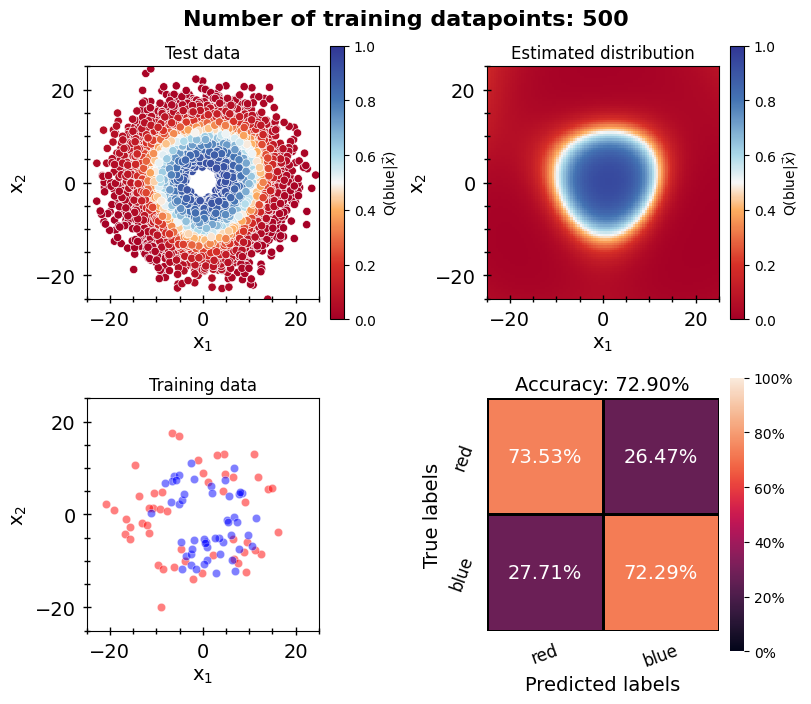

In [7]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8,7), layout="constrained")
    
#plot data
axs[0][0] = plot_results(test_data, "Confidence_blue", axs[0][0], "Test data")
axs[0][1] = plot_results(grid_data, "Confidence_blue", axs[0][1], "Estimated distribution", grid=True)
axs[1][0] = plot_data(train_data[0:100], axs[1][0], "Training data")
axs[1][1] = plot_conf_matrix(test_data, "class", "Prediction", ["red", "blue"], axs[1][1])

cmap = red_blue_cmap()
hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][0])
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][1])

fig.suptitle(f"Number of training datapoints: {n_data}", size=16, fontweight="bold")

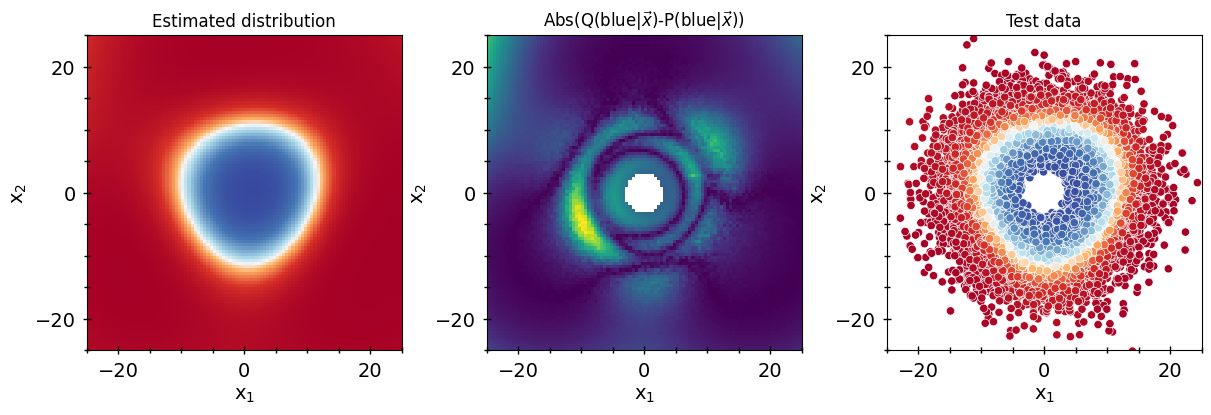

In [10]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12,4), layout="constrained")
axs[0] = plot_results(grid_data, "Confidence_blue", axs[0], "Estimated distribution", grid=True)
axs[1] = plot_diff(grid_data, truth_data, "Confidence_blue", "P_blue_given_x", axs[1], r"Abs(Q(blue|$\vec{x}$)-P(blue|$\vec{x}$))")
axs[2] = plot_results(test_data, "Confidence_blue", axs[2], "Test data")


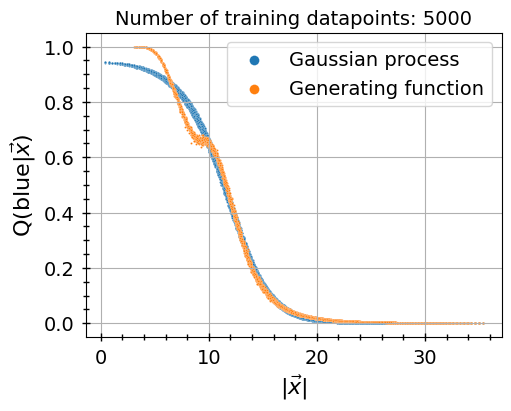

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize= (5, 4), layout="constrained")
sn.scatterplot(grid_data, x="r_x", y="Confidence_blue", s=2, ax = ax, label ="Gaussian process")
sn.scatterplot(truth_data, x="r_x", y="P_blue_given_x", s=2, ax = ax, label="Generating function")
ax.set_title(f"Number of training datapoints: {n_data}", fontsize=14)
ax.legend(markerscale=5, fontsize=14)
ax.set_xlabel(r"$|\vec{x}|$", fontsize=16)
ax.set_ylabel(r"Q(blue|$\vec{x}$)", fontsize=16)
ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
ax.tick_params(which="major", length=6)
ax.minorticks_on()
ax.grid()

In [54]:


#https://stackoverflow.com/questions/67818319/how-to-output-mean-and-stdv-of-gaussian-process-classifier-in-sklearn
class LatentGPC(GaussianProcessClassifier):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def predict_a(
        self, X: np.ndarray, return_std: bool = False
    ) -> Union[np.ndarray, Tuple[np.ndarray, np.ndarray]]:
        """
        Return estimates of the latent function for X.
        
        Notes:
        ------
        - For binary classification (n_classes = 2), the output shape is
        (n_samples,).
        - For multi-class classification, the output shape is (n_samples,
        n_classes) when multi_class="one_vs_rest", and is shaped (n_samples,
        n_classes*(n_classes - 1)/2) when multi_class="one_vs_one". In other
        terms, There are as many columns as trained Binary GPC sub-models.
        - The number of classes (n_classes) is determined by the number of
        unique target values in the training data.
        """
        check_is_fitted(self)

        if self.n_classes_ > 2:  # Multi-class case
            f_stars = []
            std_f_stars = []
            for estimator, kernel in zip(self.base_estimator_.estimators_, self.kernel_.kernels):
                result = self._binary_predict_a(estimator, kernel, X, return_std)
                if not return_std:
                    f_stars.append(result)
                else:
                    f_stars.append(result[0])
                    std_f_stars.append(result[1])

            if not return_std:
                return np.array(f_stars).T

            return np.array(f_stars).T, np.array(std_f_stars).T
        else:  # Binary case
            return self._binary_predict_a(self.base_estimator_, self.kernel_, X, return_std)

    @staticmethod
    def _binary_predict_a(estimator, kernel, X, return_std):
        """ Return mean and std of the latent function estimates for X. """
        check_is_fitted(estimator)

        # Based on Algorithm 3.2 of GPML
        K_star = kernel(estimator.X_train_, X)  # K_star = k(x_star)
        f_star = K_star.T.dot(estimator.y_train_ - estimator.pi_)  # Line 4
        if not return_std:
            return f_star

        v = solve(estimator.L_, estimator.W_sr_[:, np.newaxis] * K_star)  # Line 5
        # Line 6 (compute np.diag(v.T.dot(v)) via einsum)
        var_f_star = kernel.diag(X) - np.einsum("ij,ij->j", v, v)

        return f_star, np.sqrt(var_f_star)
    


In [55]:
gp_new = LatentGPC(kernel=kernel)
# Fit the model to the training data
gp_new.fit(X_train, Y_train)

LatentGPC()

## Not normalized

In [56]:
#samples_test = gp_new.predict_a(X_test, return_std=True)[:,0]
test_data["Logit_blue"], test_data["Std_logit_blue"] = gp_new.predict_a(X_test, return_std=True)
#test_data["Std_samples_blue"] = gp_new.predict_a(X_test, return_std=True)[:,1]
test_data["Prediction"] = gp_new.predict(X_test)
grid_data["Logit_blue"], grid_data["Std_logit_blue"] = gp_new.predict_a(X_grid, return_std=True)
grid_data["Prediction"] = gp_new.predict(X_grid)

In [57]:
test_data

,color,x1,x2,a1,a2,r1,r2,r_x,a_x,class,Confidence_blue,Prediction,Logit_blue,Std_logit_blue
0,red,4.637181,11.350187,0.935784,1.553757,11.837233,3,12.260921,1.182936,0,0.402623,0,-0.395666,0.102133
1,red,10.042744,10.382106,0.682262,0.612850,11.887063,3,14.444543,0.802012,0,0.187344,0,-1.473578,0.154992
2,blue,-5.605532,11.920284,1.943990,0.295500,10.273541,3,13.172515,2.010363,1,0.274788,0,-0.973191,0.121775
3,blue,-1.477669,-14.679668,4.577589,0.170343,11.788505,3,14.753853,4.612066,1,0.167671,0,-1.610951,0.172972
4,blue,-9.945727,8.379890,2.213879,1.781017,13.296149,3,13.005386,2.441433,1,0.293782,0,-0.879334,0.113993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,red,0.596807,9.253463,1.318706,2.526894,11.560692,3,9.272689,1.506390,0,0.710545,1,0.899053,0.083931
9996,blue,-6.404741,6.863661,1.997287,1.496279,8.674995,3,9.387787,2.321621,1,0.682754,1,0.767440,0.081478
9997,blue,-11.277142,2.093363,2.757517,0.865739,9.295702,3,11.469791,2.958053,1,0.475524,0,-0.098231,0.089528
9998,red,8.927445,11.836816,0.898653,3.012991,17.796208,3,14.825974,0.924606,0,0.154634,0,-1.707480,0.168753


Text(0.5, 0.98, 'Number of training datapoints: 5000')

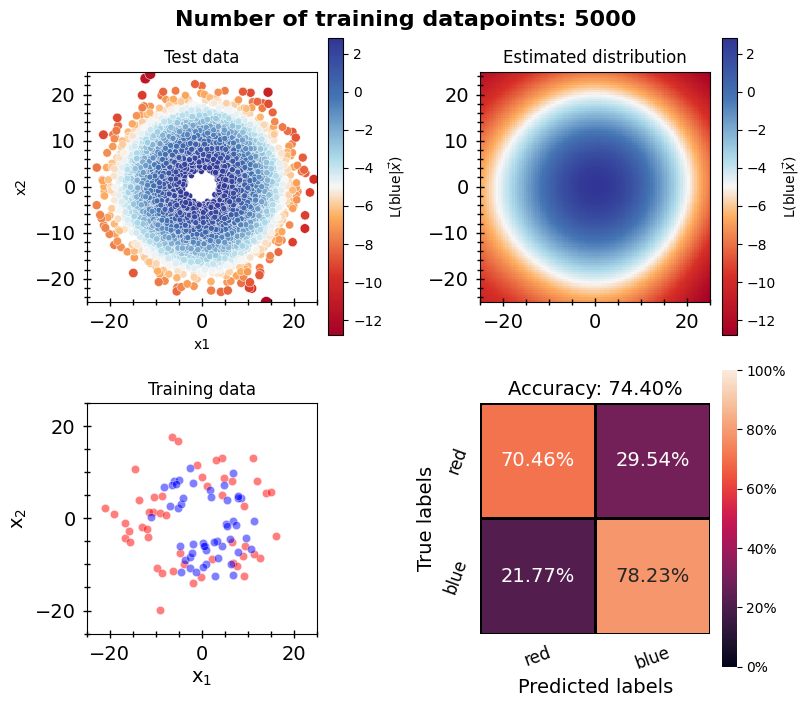

In [61]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8,7), layout="constrained")
cmap = red_blue_cmap()

#plot results
axs[0][0] = plot_logit_results(test_data, "Logit_blue", axs[0][0], "Test data", error_key="Std_logit_blue")
hue_norm = mpl.colors.Normalize(vmin=grid_data["Logit_blue"].min(), vmax=grid_data["Logit_blue"].max(), clip=False)

fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"L(blue|$\vec{x}$)", ax=axs[0][0])
axs[0][1] = plot_logit_results(grid_data, "Logit_blue", axs[0][1], "Estimated distribution", grid=True)

hue_norm = mpl.colors.Normalize(vmin=grid_data["Logit_blue"].min(), vmax=grid_data["Logit_blue"].max(), clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"L(blue|$\vec{x}$)", ax=axs[0][1])

axs[1][0] = plot_data(train_data[0:100], axs[1][0], "Training data")
axs[1][1] = plot_conf_matrix(test_data, "class", "Prediction", ["red", "blue"], axs[1][1])



fig.suptitle(f"Number of training datapoints: {n_data}", size=16, fontweight="bold")

Text(0.5, 0.98, 'Number of datapoints: 5000')

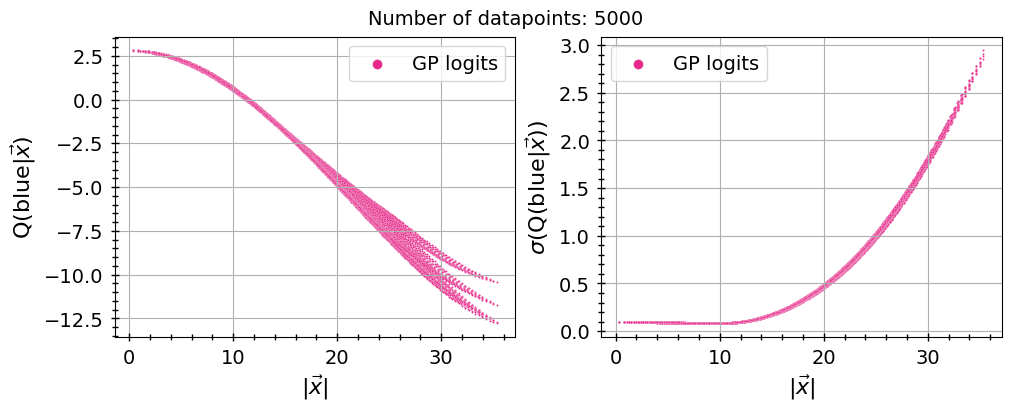

In [60]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
sn.scatterplot(grid_data, x="r_x", y="Logit_blue", s=2, ax = axs[0], label="GP logits", color="#e7298a")
#sn.lineplot(truth_data, x="r_x", y="P_blue_given_x", linewidth=2, ax = axs[0], label="Generating function", color="#67001f")
axs[0].set_ylabel(r"Q(blue|$\vec{x}$)", fontsize=16)

sn.scatterplot(grid_data, x="r_x", y="Std_logit_blue", s=2, ax = axs[1], label="GP logits", color="#e7298a")
axs[1].set_ylabel(r"$\sigma$(Q(blue|$\vec{x}$))", fontsize=16)
#axs[1].set_ylim(0, 0.3)

for ax in axs:
    ax.legend(markerscale=5, fontsize=14)
    ax.set_xlabel(r"$|\vec{x}|$", fontsize=16)
    ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
    ax.tick_params(which="major", length=6)
    ax.minorticks_on()
    ax.grid()
fig.suptitle(f"Number of datapoints: {n_data}", fontsize=14)